In [1]:
try:
    import urllib2 as urllib
except ImportError:
    import urllib as urlb
import os
import sys
import io
from pandas import Series

In [2]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import geopandas as gpd
from shapely.geometry import shape  
import osr
import requests
import matplotlib.pyplot as plt
%matplotlib inline

# 1. PUMA : Public Use Microdata Area

## 1.1 download the NYC Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

In [3]:
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"

In [4]:
urlb.request.urlretrieve(url, "file.gz")

('file.gz', <http.client.HTTPMessage at 0x7ff1701b1c88>)

In [5]:
# ove the downloaded data to PUI data
print("PUIDATA", os.getenv("PUIDATA"))

PUIDATA /nfshome/ys3226/PUIdata


In [6]:
#create the env variable if missing
os.environ["PUIDATA"] = "%s/PUIDATA"%os.getenv("HOME")

print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/ys3226/PUIDATA


In [7]:
# unpacking into $PUIDATA
!unzip file.gz -d $PUIDATA

Archive:  file.gz
  inflating: /nfshome/ys3226/PUIDATA/geo_export_ef58af09-7f0e-457a-b1dd-b5f7608824d5.dbf  
  inflating: /nfshome/ys3226/PUIDATA/geo_export_ef58af09-7f0e-457a-b1dd-b5f7608824d5.shp  
  inflating: /nfshome/ys3226/PUIDATA/geo_export_ef58af09-7f0e-457a-b1dd-b5f7608824d5.shx  
  inflating: /nfshome/ys3226/PUIDATA/geo_export_ef58af09-7f0e-457a-b1dd-b5f7608824d5.prj  


In [8]:
#test if the data is there
!ls $PUIDATA

ACS_16_1YR_GCT2801.ST50_metadata.csv
ACS_16_1YR_GCT2801.ST50.txt
ACS_16_1YR_GCT2801.ST50_with_ann.csv
aff_download_readme_ann.txt
bkmerged.csv
busdata.txt
citibike201801.zip
citibike201806.zip
citibike201807.csv
citibike201807.zip
citybike.zip
geo_export_0c9ac4f9-95dc-417f-82cc-23ec08a71970.dbf
geo_export_0c9ac4f9-95dc-417f-82cc-23ec08a71970.prj
geo_export_0c9ac4f9-95dc-417f-82cc-23ec08a71970.shp
geo_export_0c9ac4f9-95dc-417f-82cc-23ec08a71970.shx
geo_export_2eca3aa3-cc88-4b82-a64d-ec5a35cfd712.dbf
geo_export_2eca3aa3-cc88-4b82-a64d-ec5a35cfd712.prj
geo_export_2eca3aa3-cc88-4b82-a64d-ec5a35cfd712.shp
geo_export_2eca3aa3-cc88-4b82-a64d-ec5a35cfd712.shx
geo_export_394e57a8-3e3e-4828-b2df-9179aab4abc8.dbf
geo_export_394e57a8-3e3e-4828-b2df-9179aab4abc8.prj
geo_export_394e57a8-3e3e-4828-b2df-9179aab4abc8.shp
geo_export_394e57a8-3e3e-4828-b2df-9179aab4abc8.shx
geo_export_5c6ba704-752c-4a9a-bf1b-24baeaa73bda.dbf
geo_export_5c6ba704-752c-4a9a-bf1b-24baeaa73bda.prj
geo_export_5c6ba704-752c-4a9

In [9]:
pumashp = gpd.GeoDataFrame.from_file("%s/geo_export_dae87114-9002-4016-b067-c7b122f00335.shp"%os.getenv("PUIDATA"))

In [10]:
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [11]:
pumashp.crs

{'init': 'epsg:4326'}

In [12]:
##cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=2)

## 1.2 plot the PUMA NYC regions

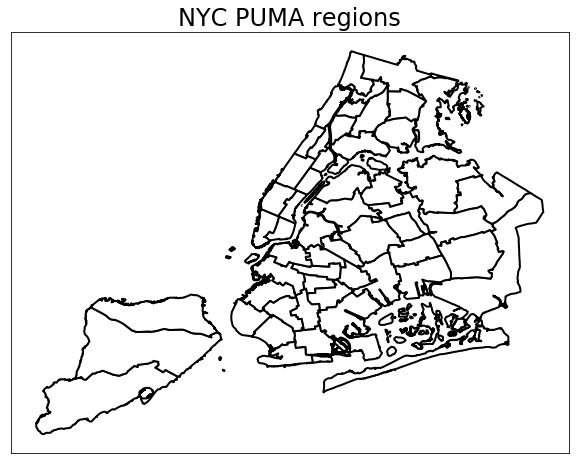

In [13]:
ax = pumashp.plot(column=None, color="white", edgecolor="black", lw=2, figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('NYC PUMA regions', fontsize=24)
plt.show()

   Figure 1: Representation of NYC in black and white by PUMA regions

# 2. American Fact Finder data on percentage of houses with broadband internet access

## 2.1 Get data with American Fact Finder (AFF) API:

In [14]:
import json
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [15]:
#turning things into arrays to enable broadcasting
affkeys = np.array(list(aff1y['variables'].keys()))

We need two features: **total number of households**, and **number of households with broadband access**

In [16]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL')]

In [17]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [18]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

In [19]:
from myCensus import myAPI

In [20]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [21]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

In [22]:
pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 2.2 generate a feature for the percentage of households with broadband access

In [23]:
puma_merged = pumaBB.merge(pumaPP, left_on='public use microdata area', right_on='public use microdata area', how='inner')

In [24]:
puma_merged.drop(['Unnamed: 4_x', 'NAME_y', 'state_y', 'Unnamed: 4_y'], axis=1, inplace=True)

In [25]:
puma_merged = puma_merged.rename(index=str, columns={"NAME_x": "NAME", "state_x": "state"})
puma_merged.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E
0,32607,"St. Lawrence County PUMA, New York",36,100,40479
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146


In [26]:
puma_merged['pcBB'] = (puma_merged['B28002_004E'] / puma_merged['B28002_001E']) * 100
puma_merged.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


In [73]:
puma_merged['public use microdata area'][0]

100

## 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

In [74]:
# unpacking into $PUIDATA
!unzip aff_download.zip -d $PUIDATA

Archive:  aff_download.zip
replace /nfshome/ys3226/PUIDATA/ACS_16_1YR_GCT2801.ST50_with_ann.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [29]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8


In [30]:
bbpc.drop(0, inplace=True)

In [31]:
bbpc['GCT_STUB.target-geo-id2'] = bbpc['GCT_STUB.target-geo-id2'].astype('int64')

In [32]:
#bbpc['gid'] = bbpc['GCT_STUB.target-geo-id2'].str[3:]

In [33]:
#bbpc['gid'].replace('', np.nan, inplace=True)

In [34]:
#bbpc.dropna(subset=['gid'], inplace=True)

In [35]:
bbpc['gid'] = bbpc['GCT_STUB.target-geo-id2'] - 3600000

In [36]:
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02,gid
1,1,74.7,0.5,-3599999
2,100100,70.9,2.5,-3499900
3,100200,80.5,2.7,-3499800
4,100301,87.0,2.8,-3499699
5,100302,81.9,2.9,-3499698


In [37]:
#bbpc.drop(['GCT_STUB.target-geo-id2'], axis=1, inplace=True)

### check that the percentage of households with broadband you generated and the one you red in from the table you downloaded manually are the same

In [38]:
diff_ = puma_merged.merge(bbpc, right_on='gid', 
                     left_on='public use microdata area', how='inner')[['pcBB', 'HC01']]
diff_['HC01'] = diff_['HC01'].astype(float)
diff_['diff'] = np.abs(diff_['pcBB'] - diff_['HC01'])
diff_.head()
diff_.describe()

,pcBB,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


# 3 Plot a choropleth of NYC broadband access

## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [39]:
#choropleth of the percentage of internet axcess
pumashp['puma'] = pumashp['puma'].astype('int64')
pumashp_merged = pumashp.merge(puma_merged, right_on='public use microdata area', left_on='puma', how='inner')
#pumashp.head()

pumashp_merged.head()
#cp.choroplethNYC(...);

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,55953,78.778618


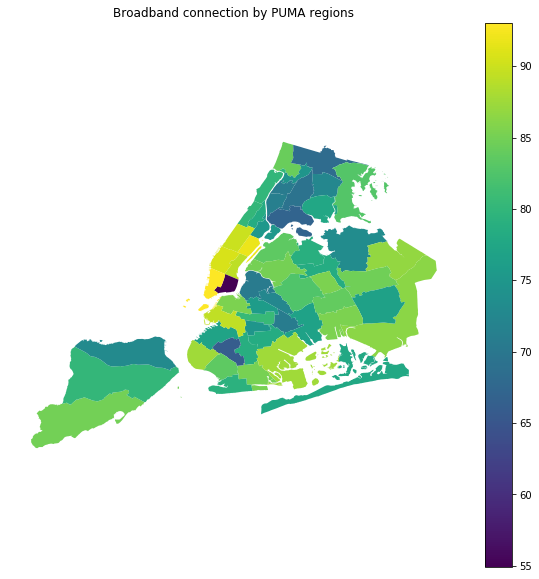

In [40]:
from matplotlib.colors import Normalize
from matplotlib import cm
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
im = pumashp_merged.plot(column='pcBB',alpha=1,linewidth=0.5,ax=ax, cmap='viridis')
norm = Normalize(vmin=pumashp_merged['pcBB'].min(), vmax=pumashp_merged['pcBB'].max())
n_cmap = cm.ScalarMappable(norm=norm, cmap='viridis')
n_cmap.set_array([])
ax.get_figure().colorbar(n_cmap)
ax.set_axis_off()
plt.axis('equal')
plt.title("Broadband connection by PUMA regions")
plt.show()

   Figure 2: Percentages of Broadband Internet connection in NYC by PUMA regions. (Add colorbar)

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

In [41]:
!curl https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW7_fb55/linkNYClocations.csv > linkNYC.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75571  100 75571    0     0   345k      0 --:--:-- --:--:-- --:--:--  346k


In [42]:
# move the data
!mv linkNYC.csv $PUIDATA

In [43]:
linkNYC = pd.read_csv("%s/linkNYC.csv"%os.getenv("PUIDATA"))

In [44]:
linkNYC.drop(['Unnamed: 0'], axis=1, inplace=True)
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [45]:
linkNYC.shape

(1414, 4)

In [46]:
import shapely
# combine lat and lon to one column
linkNYC['lonlat']=list(zip(linkNYC.longitude,linkNYC.latitude))
# Create Point Geometry for based on lonlat column
linkNYC['geometry']=linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [47]:
from geopandas import GeoDataFrame
linkNYC = GeoDataFrame(linkNYC)

In [48]:
from fiona.crs import from_epsg
linkNYC.crs = from_epsg(4326)
linkNYC.crs

{'init': 'epsg:4326', 'no_defs': True}

In [49]:
# ax = pumashp.plot(column=None, color="white", edgecolor="black", lw=2, figsize=(10,10))

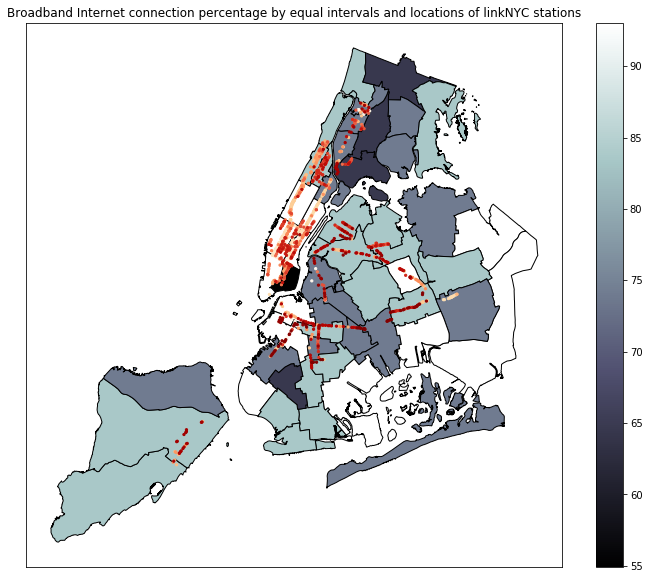

In [50]:
f, ax = plt.subplots(figsize=(12,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pumashp_merged.plot(column='pcBB',cmap='bone',alpha=1,
                  lw=1, ax=ax, scheme="Equal_interval", edgecolor="black", legend=False, k=5)
linkNYC.plot(ax=ax, marker='o', c="date_link_", 
             markersize=5, cmap="OrRd")
n_cmap = cm.ScalarMappable(norm=norm, cmap='bone')
n_cmap.set_array([])
ax.get_figure().colorbar(n_cmap)
plt.title("Broadband Internet connection percentage by equal intervals and locations of linkNYC stations")
plt.show()

  Figure 3: Broadband Internet connection percentage by equal intervals and locations of linkNYC stations

# 5 Find the number of linkNYC locations per person by PUMA

## 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

In [51]:
#keyword for the total pop of households
keyNtotpop = 'B00001_001E'
aff1y['variables'][keyNtotpop]

{'attributes': 'B00001_001EA',
 'concept': 'UNWEIGHTED SAMPLE COUNT OF THE POPULATION',
 'group': 'B00001',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [52]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNtotpop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [53]:
pumashp = pumashp_merged.merge(pumaPop, left_on="puma", right_on="public use microdata area")

In [54]:
pumashp.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME_x,state_x,public use microdata area_x,B28002_001E,pcBB,B00001_001E,NAME_y,state_y,public use microdata area_y,Unnamed: 4
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,55953,78.778618,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,NaN


## 5.2 find the number of station per 100 people per PUMA

In [55]:
#set coordinates to flat plane
pumashp = pumashp.to_crs(epsg=2263)

In [56]:
#set coordinates to flat plane
linkNYC = linkNYC.to_crs(epsg=2263)

create a geodataframe with a spatial join and use groupby to count the number of linkNYC in each PUMA

In [57]:
#spatial join to "within"
linkpp = gpd.sjoin(linkNYC, pumashp)[["puma", "link_site"]].groupby("puma").count()
linkpp.head()

,link_site
puma,
3701,1
3705,1
3706,20
3707,29
3708,19


finally merge back into the pumashp. Make sure you use the correct scheme for merging: you want to have all the PUMAs, not only the ones that have linkNYC in them in the final geoDF

In [58]:
#merge outer so as to not to lose pumas
pumashplc = pumashp.merge(linkpp, left_on="puma", right_index=True, how="outer")

In [59]:
pumashplc.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME_x,state_x,public use microdata area_x,B28002_001E,pcBB,B00001_001E,NAME_y,state_y,public use microdata area_y,Unnamed: 4,link_site
index_right,,,,,,,,,,,,,,,,
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,1.0
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,NaN
2,3703,2.670137e+08,304071.257466,(POLYGON ((1042822.450195312 243439.8142089319...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,NaN
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,NaN
4,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,55953,78.778618,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,NaN,3.0


In [60]:
#linkNYC per 100 inhabitants
pumashplc["linkNYCpp"] = pumashplc["link_site"] / pumashplc["B00001_001E"] * 100
pumashplc["linkNYCpp"].dropna().describe()

count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%       0.538358
50%       1.299590
75%       1.873385
max      15.141540
Name: linkNYCpp, dtype: float64

## at last, plot the linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


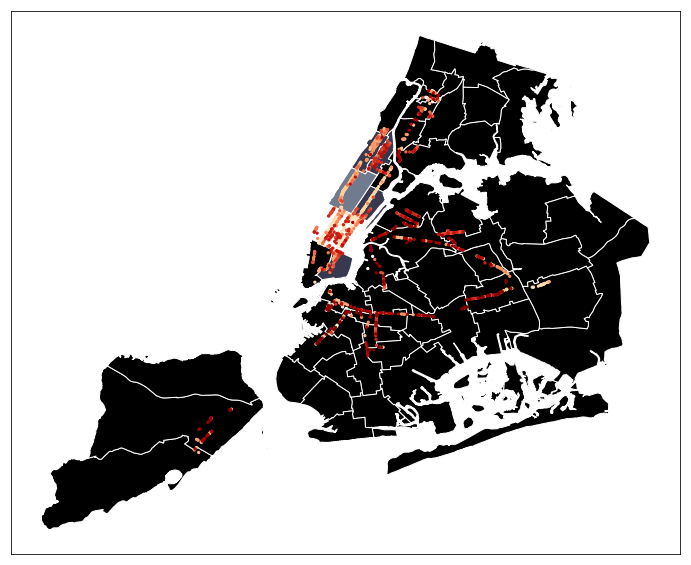

In [61]:
f, ax = plt.subplots(figsize=(12,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pumashplc.plot(column='linkNYCpp',cmap='bone',alpha=1,
                  lw=1, ax=ax, scheme="Equal_interval", edgecolor="white", legend=False, k=5)
linkNYC.plot(ax=ax, marker='o', c="date_link_", 
             markersize=5, cmap="OrRd")
n_cmap = cm.ScalarMappable(norm=norm, cmap='bone')
n_cmap.set_array([])
#ax.get_figure().colorbar(n_cmap)
#plt.title("Broadband Internet connection percentage by equal intervals and locations of linkNYC stations")
plt.show()

Figure 4: The linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals. The only bright color seen in Manhattan represents a high concentration of linkNYC hubs.

## Extra credit 1:

In [62]:
pumashplc[['linkNYCpp']].ix[:9,:]

,linkNYCpp
index_right,
0,0.065920
1,NaN
2,NaN
3,NaN
4,0.119284
5,NaN
6,0.049727
7,1.569859
8,1.873385


In [63]:
pumashplc.linkNYCpp[np.isnan(pumashplc.linkNYCpp)] = np.nanmin(pumashplc.linkNYCpp)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


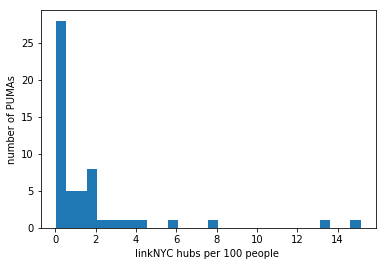

In [64]:
ax = plt.figure().add_subplot(111)
ax.hist(pumashplc.linkNYCpp, bins=30);
ax.set_xlabel("linkNYC hubs per 100 people ")
ax.set_ylabel("number of PUMAs")
plt.show()

Figure 5: The distribution of linkNYC hubs per 100 people in terms of PUMA region. Because of the concentration on very low numbers, it would be better to look at the numbers in log-scale.

In [65]:
pumashplc["loglinkNYCpp"] = np.log10(pumashplc["linkNYCpp"])
pumashplc["loglinkNYCpp"][~np.isfinite(pumashplc["loglinkNYCpp"])] = \
        pumashplc["loglinkNYCpp"][np.isfinite(pumashplc["loglinkNYCpp"])].min() -1

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [66]:
pumashplc.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,puma,shape_area,shape_leng,B28002_004E,state_x,public use microdata area_x,B28002_001E,pcBB,B00001_001E,state_y,public use microdata area_y,Unnamed: 4,link_site,linkNYCpp,loglinkNYCpp
count,55.000000,5.500000e+01,55.000000,55.000000,55.0,55.000000,55.000000,55.000000,55.000000,55.0,55.000000,0.0,37.000000,55.000000,55.000000
mean,3936.218182,1.532632e+08,91547.959548,45287.254545,36.0,3936.218182,56633.272727,79.462797,2138.618182,36.0,3936.218182,NaN,38.216216,1.582166,-0.400609
std,149.997616,1.361440e+08,77522.481125,14410.514427,0.0,149.997616,14874.212875,7.548276,699.237163,0.0,149.997616,NaN,46.499782,2.924306,0.797890
min,3701.000000,3.984279e+07,34852.437966,27834.000000,36.0,3701.000000,37998.000000,54.932945,1238.000000,36.0,3701.000000,NaN,1.000000,0.049727,-1.303412
25%,3804.500000,7.498814e+07,48072.809133,35658.500000,36.0,3804.500000,45822.500000,74.772059,1554.000000,36.0,3804.500000,NaN,NaN,0.049727,-1.303412
50%,4005.000000,1.070001e+08,70492.955589,41578.000000,36.0,4005.000000,52591.000000,79.301693,2004.000000,36.0,4005.000000,NaN,NaN,0.538358,-0.268929
75%,4059.500000,1.692189e+08,98789.538654,50273.000000,36.0,4059.500000,62501.500000,85.127599,2383.500000,36.0,4059.500000,NaN,NaN,1.646966,0.216500
max,4114.000000,6.760200e+08,412606.741739,102520.000000,36.0,4114.000000,111507.000000,93.030650,4001.000000,36.0,4114.000000,NaN,230.000000,15.141540,1.180170


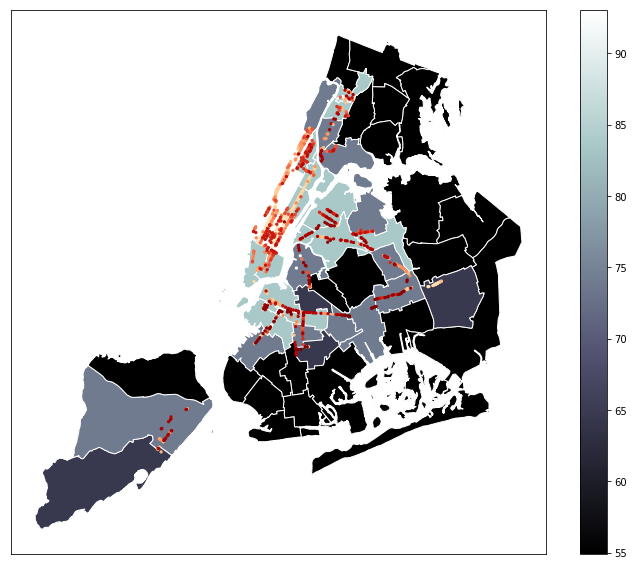

In [67]:
f, ax = plt.subplots(figsize=(12,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pumashplc.plot(column='loglinkNYCpp',cmap='bone',alpha=1,
                  lw=1, ax=ax, scheme="Equal_interval", edgecolor="white", legend=False, k=5)
linkNYC.plot(ax=ax, marker='o', c="date_link_", 
             markersize=5, cmap="OrRd")
n_cmap = cm.ScalarMappable(norm=norm, cmap='bone')
n_cmap.set_array([])
ax.get_figure().colorbar(n_cmap)
#plt.title("Broadband Internet connection percentage by equal intervals and locations of linkNYC stations")
plt.show()

Figure 6: The linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals just like in the Figure 4, however more reader friendly in terms of the colormap thanks to log-scale.

## Extra Credit 2:

plot Spatial Lag Deciles that describe the impact of linkNYC in providing access where needed. You can follow what you did in the lab, but you need to create a metric based on the data you have tha measures the impact of linkNYC

In [68]:
%mkdir Output

mkdir: cannot create directory ‘Output’: File exists


In [69]:
path='Output/pumashp.shp'
pumashp.to_file(path)

In [70]:
import pysal as ps
qW_CT=ps.queen_from_shapefile(path)

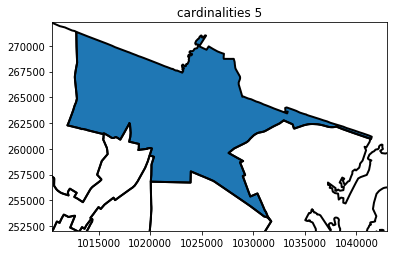

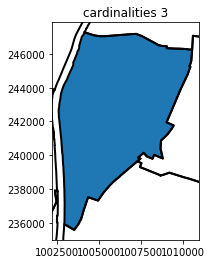

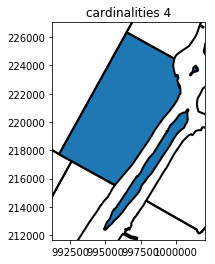

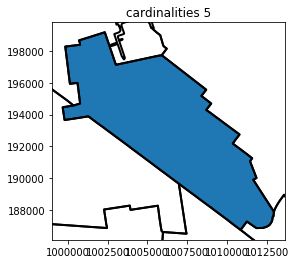

In [71]:
#cardinalities of the 10th puma
for i in 1, 10, 20, 30:
    ax = pumashp[i:i+1].plot()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax = pumashp.plot(color="None",ax=ax, linewidth=2, edgecolor="k")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title("cardinalities %d"%qW_CT.cardinalities[i])

In [72]:
# the weight matrix
Wmatrix, ids = qW_CT.full()
Wmatrix

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])